# Import thu vien

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import timm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test

[0 1 2 3 4]


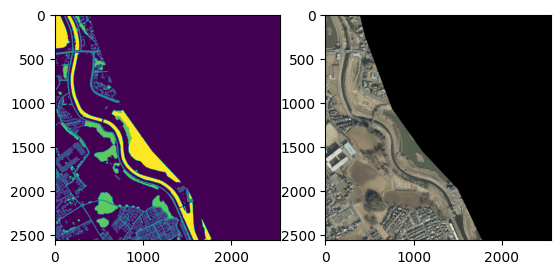

In [ ]:
mask_path = "/content/drive/MyDrive/NAVER/Mask2_resample/Mask_Row(249)_Col(322)_resample.tif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img_path = "/content/drive/MyDrive/NAVER/TrueOrtho_resample/Ortho_Row(249)_Col(322)_resample.tif"
img= cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(img)
print(np.unique(mask))

# Tao CustomDataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, root_dir, txt_file, transform = None):
    super().__init__()
    self.root_dir = root_dir
    self.txt_file= txt_file
    self.transform = transform
    self.img_path_list = []
    with open(self.txt_file) as file_in:
      for line in file_in:
        self.img_path_list.append(line)

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    filename = self.img_path_list[idx]
    base, ext = os.path.splitext(filename)
    resample_filename1 = f"{base}{ext}"
    base2 = base.replace('Ortho', 'Mask')
    resample_filename2 = f"{base2}{ext}"

    image_path = os.path.join(self.root_dir,"TrueOrtho_resample", resample_filename1.strip())
    mask_path = os.path.join(self.root_dir,"Mask2_resample", resample_filename2.strip())
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if self.transform is not None:
      transformed = self.transform(image = image, mask = mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

# Augmentation anh

In [ ]:
train_transformed = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5), # Added probability for flip
    A.VerticalFlip(p=0.5), # Added vertical flip
    A.RandomRotate90(), # Added random rotation
    A.Transpose(p=0.5), # Added transpose
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, border_mode=cv2.BORDER_REFLECT), # Added shift, scale, rotate
    A.RandomBrightnessContrast(p=0.2), # Added probability for brightness contrast
    A.Blur(blur_limit=3), # Specified blur limit
    A.OpticalDistortion(), # Added optical distortion
    A.GridDistortion(), # Added grid distortion
    A.HueSaturationValue(), # Added hue saturation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


test_transformed = A.Compose([
    A.Resize(width=2048, height=2048),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

val_transformed = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


In [ ]:
train_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/train.txt", train_transformed)
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)
val_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/val.txt", val_transformed)
train_dataset.__getitem__(90)


(tensor([[[-0.8164, -0.9020, -1.0733,  ..., -0.3027, -0.3027,  0.5022],
          [-0.7308, -0.8507, -1.0390,  ..., -0.4054, -0.4054,  0.4166],
          [-0.7479, -0.8335, -0.9877,  ..., -0.5253, -0.5253,  0.2796],
          ...,
          [-0.4397, -0.1999,  0.2282,  ..., -0.0629, -0.0629, -0.4739],
          [-0.4397, -0.1999,  0.2282,  ..., -0.0629, -0.0629, -0.4739],
          [ 0.9817,  0.8276,  0.3652,  ..., -0.3883, -0.3883, -0.4911]],
 
         [[-0.6001, -0.6877, -0.8627,  ..., -0.2675, -0.2675,  0.5903],
          [-0.5301, -0.6352, -0.8277,  ..., -0.3200, -0.3200,  0.5203],
          [-0.5301, -0.6001, -0.7577,  ..., -0.4076, -0.4076,  0.3978],
          ...,
          [-0.2675, -0.0224,  0.3452,  ..., -0.0924, -0.0924, -0.2325],
          [-0.2675, -0.0224,  0.3452,  ..., -0.0924, -0.0924, -0.2325],
          [ 1.1155,  0.9580,  0.4503,  ..., -0.3200, -0.3200, -0.3550]],
 
         [[-0.4275, -0.5147, -0.6541,  ..., -0.4101, -0.4101,  0.4962],
          [-0.3927, -0.4798,

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


# U Net model

In [ ]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class ResUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet152", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(2048, 1024)
        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Tinh Accuracy

In [ ]:
def accuracy_function(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    acc_class = []
    for i in range(5):  # Assuming 5 classes
        indices = targets_flat == i
        total = indices.sum().item()
        if total > 0:
            correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
            acc_class.append(correct / total)
    return sum(acc_class) / len(acc_class) if acc_class else 0

def recall(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    indices = targets_flat == 1
    total = indices.sum().item()
    if total > 0:
        correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
        return correct / total
    return 0

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
#model
model = ResUnet(5).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_eps = 300

#metrics
dice_fn = torchmetrics.Dice(num_classes=5, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=5, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()
recall_meter = AverageMeter()

num_workers = 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Train

In [ ]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler
scaler = GradScaler()

# Set the number of accumulation steps
accumulation_steps = 8 # Adjust this value according to your memory limit

best_val_loss = float('inf')
accs = []
train_losses =[]
val_losses = []
dices = []
ious = []
best_epoch_preds, best_epoch_targets = None, None

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    recall_meter.reset()
    model.train()

    optimizer.zero_grad()  # Reset gradients tensors

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device)
        y = y.to(device).long()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        loss = criterion(y_hat, y)
        loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # Backward passes without optimization every few batches
        if (batch_id + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1)
            dice_score = dice_fn(y_hat_mask, y)
            accuracy = accuracy_function(y_hat_mask, y)
            dice_score = dice_fn(y_hat_mask, y)
            iou_score = iou_fn(y_hat_mask,y)
            recall_score = recall(y_hat_mask, y)

            train_loss_meter.update(loss.item() * accumulation_steps, n)  # We have to scale our loss back
            dice_meter.update(dice_score, n)
            iou_meter.update(iou_score,n)
            acc_meter.update(accuracy, n)
            recall_meter.update(recall_score, n)

    accs.append(acc_meter.avg)
    train_losses.append(train_loss_meter.avg)
    model.eval()
    val_loss_meter = AverageMeter()
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device).long()
            y_hat = model(x)
            y_hat = y_hat.squeeze()
            loss = criterion(y_hat, y)
            val_loss_meter.update(loss, x.size(0))

    val_loss = val_loss_meter.avg
    dices.append(dice_meter.avg.cpu().item())
    val_losses.append(val_loss_meter.avg.cpu().item())
    ious.append(iou_meter.avg.cpu().item())
    print("EP {}, val loss = {:.6}".format(ep, val_loss))
    print("EP {}, train loss = {:.6f}, accuracy = {:.6f}, iou = {:.6f}, dice = {:.6f}, recall= {:.6f}".format(
       ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg, recall_meter.avg
    ))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/best_model.pth")
        best_epoch_preds = y_hat.argmax(dim=1).view(-1).cpu().numpy()
        best_epoch_targets = y.view(-1).cpu().numpy()

100%|██████████| 14/14 [00:54<00:00,  3.87s/it]


EP 1, val loss = 12.8712
EP 1, train loss = 7.089906, accuracy = 0.185404, iou = 0.073207, dice = 0.086248, recall= 0.000879


100%|██████████| 14/14 [00:30<00:00,  2.18s/it]


EP 2, val loss = 1.09846
EP 2, train loss = 6.663763, accuracy = 0.200778, iou = 0.141774, dice = 0.166535, recall= 0.004012


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 3, val loss = 1.1022
EP 3, train loss = 1.023656, accuracy = 0.200911, iou = 0.141938, dice = 0.167271, recall= 0.004642


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 4, val loss = 1.05201
EP 4, train loss = 0.967969, accuracy = 0.200207, iou = 0.141304, dice = 0.165530, recall= 0.000998


100%|██████████| 14/14 [00:31<00:00,  2.24s/it]


EP 5, val loss = 1.11067
EP 5, train loss = 0.928221, accuracy = 0.202731, iou = 0.143501, dice = 0.167085, recall= 0.000013


100%|██████████| 14/14 [00:30<00:00,  2.17s/it]


EP 6, val loss = 1.23875
EP 6, train loss = 0.933259, accuracy = 0.200000, iou = 0.140610, dice = 0.164775, recall= 0.000000


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 7, val loss = 1.24904
EP 7, train loss = 0.914308, accuracy = 0.200000, iou = 0.140847, dice = 0.165078, recall= 0.000001


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 8, val loss = 1.18511
EP 8, train loss = 0.882217, accuracy = 0.200022, iou = 0.141025, dice = 0.165015, recall= 0.000112


100%|██████████| 14/14 [00:31<00:00,  2.22s/it]


EP 9, val loss = 1.14253
EP 9, train loss = 0.859342, accuracy = 0.202672, iou = 0.144096, dice = 0.169799, recall= 0.013649


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 10, val loss = 1.11019
EP 10, train loss = 0.865031, accuracy = 0.204809, iou = 0.146104, dice = 0.173583, recall= 0.024426


100%|██████████| 14/14 [00:28<00:00,  2.07s/it]


EP 11, val loss = 1.05581
EP 11, train loss = 0.856235, accuracy = 0.204140, iou = 0.145535, dice = 0.173226, recall= 0.021862


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 12, val loss = 1.03554
EP 12, train loss = 0.834683, accuracy = 0.207487, iou = 0.147728, dice = 0.175806, recall= 0.039120


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 13, val loss = 0.982291
EP 13, train loss = 0.829910, accuracy = 0.200421, iou = 0.141371, dice = 0.165771, recall= 0.002151


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 14, val loss = 0.964117
EP 14, train loss = 0.830509, accuracy = 0.202180, iou = 0.142513, dice = 0.168623, recall= 0.011030


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 15, val loss = 0.962918
EP 15, train loss = 0.816035, accuracy = 0.204998, iou = 0.146070, dice = 0.173740, recall= 0.026181


100%|██████████| 14/14 [00:30<00:00,  2.17s/it]


EP 16, val loss = 0.917373
EP 16, train loss = 0.804472, accuracy = 0.210190, iou = 0.151518, dice = 0.184507, recall= 0.053870


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 17, val loss = 0.887874
EP 17, train loss = 0.796764, accuracy = 0.216090, iou = 0.156887, dice = 0.193185, recall= 0.091383


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 18, val loss = 0.860011
EP 18, train loss = 0.791100, accuracy = 0.219630, iou = 0.159521, dice = 0.197526, recall= 0.107129


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 19, val loss = 0.827567
EP 19, train loss = 0.805607, accuracy = 0.219992, iou = 0.156888, dice = 0.193300, recall= 0.112075


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 20, val loss = 0.826219
EP 20, train loss = 0.787300, accuracy = 0.216726, iou = 0.154579, dice = 0.188040, recall= 0.091432


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 21, val loss = 0.800733
EP 21, train loss = 0.785212, accuracy = 0.223759, iou = 0.155547, dice = 0.188468, recall= 0.097871


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 22, val loss = 0.799629
EP 22, train loss = 0.761566, accuracy = 0.226141, iou = 0.162880, dice = 0.201993, recall= 0.146730


100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


EP 23, val loss = 0.82026
EP 23, train loss = 0.779130, accuracy = 0.247953, iou = 0.173510, dice = 0.217772, recall= 0.260340


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 24, val loss = 0.853015
EP 24, train loss = 0.755781, accuracy = 0.223434, iou = 0.162857, dice = 0.201657, recall= 0.126935


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 25, val loss = 0.849932
EP 25, train loss = 0.745155, accuracy = 0.239948, iou = 0.168721, dice = 0.209565, recall= 0.226590


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 26, val loss = 0.837471
EP 26, train loss = 0.735616, accuracy = 0.262604, iou = 0.185501, dice = 0.235011, recall= 0.356941


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 27, val loss = 0.807927
EP 27, train loss = 0.723166, accuracy = 0.243938, iou = 0.168809, dice = 0.209251, recall= 0.243301


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 28, val loss = 0.823015
EP 28, train loss = 0.744685, accuracy = 0.229471, iou = 0.164544, dice = 0.203285, recall= 0.156262


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 29, val loss = 0.845064
EP 29, train loss = 0.708726, accuracy = 0.244142, iou = 0.175562, dice = 0.220631, recall= 0.245907


100%|██████████| 14/14 [00:30<00:00,  2.21s/it]


EP 30, val loss = 0.851931
EP 30, train loss = 0.724794, accuracy = 0.261015, iou = 0.186360, dice = 0.236749, recall= 0.344738


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 31, val loss = 0.839239
EP 31, train loss = 0.711498, accuracy = 0.240338, iou = 0.177595, dice = 0.222765, recall= 0.219793


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 32, val loss = 0.82551
EP 32, train loss = 0.715071, accuracy = 0.236920, iou = 0.169767, dice = 0.213320, recall= 0.202461


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 33, val loss = 0.815587
EP 33, train loss = 0.700739, accuracy = 0.255287, iou = 0.186299, dice = 0.236373, recall= 0.310854


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 34, val loss = 0.79092
EP 34, train loss = 0.693836, accuracy = 0.254801, iou = 0.189007, dice = 0.239600, recall= 0.307369


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 35, val loss = 0.781416
EP 35, train loss = 0.691458, accuracy = 0.251472, iou = 0.185579, dice = 0.234693, recall= 0.282854


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 36, val loss = 0.762161
EP 36, train loss = 0.709350, accuracy = 0.271440, iou = 0.190759, dice = 0.240882, recall= 0.391028


100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


EP 37, val loss = 0.728921
EP 37, train loss = 0.717922, accuracy = 0.263867, iou = 0.188612, dice = 0.239094, recall= 0.351314


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 38, val loss = 0.757903
EP 38, train loss = 0.682438, accuracy = 0.282396, iou = 0.196174, dice = 0.249259, recall= 0.480546


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 39, val loss = 0.741319
EP 39, train loss = 0.682759, accuracy = 0.308073, iou = 0.209558, dice = 0.267306, recall= 0.634214


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 40, val loss = 0.683333
EP 40, train loss = 0.693256, accuracy = 0.285432, iou = 0.200334, dice = 0.253918, recall= 0.485570


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 41, val loss = 0.654757
EP 41, train loss = 0.678681, accuracy = 0.243186, iou = 0.181382, dice = 0.229935, recall= 0.232585


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 42, val loss = 0.694585
EP 42, train loss = 0.681998, accuracy = 0.257007, iou = 0.188241, dice = 0.238219, recall= 0.308371


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 43, val loss = 0.751088
EP 43, train loss = 0.695552, accuracy = 0.307650, iou = 0.206757, dice = 0.262522, recall= 0.622639


100%|██████████| 14/14 [00:30<00:00,  2.14s/it]


EP 44, val loss = 0.762072
EP 44, train loss = 0.725704, accuracy = 0.319979, iou = 0.211850, dice = 0.268825, recall= 0.712579


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 45, val loss = 0.729248
EP 45, train loss = 0.673217, accuracy = 0.270173, iou = 0.195173, dice = 0.246415, recall= 0.401248


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 46, val loss = 0.692219
EP 46, train loss = 0.699226, accuracy = 0.227725, iou = 0.169396, dice = 0.213686, recall= 0.112639


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 47, val loss = 0.670247
EP 47, train loss = 0.686408, accuracy = 0.253285, iou = 0.194537, dice = 0.251710, recall= 0.136024


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 48, val loss = 0.677207
EP 48, train loss = 0.686298, accuracy = 0.275709, iou = 0.211990, dice = 0.278339, recall= 0.255637


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 49, val loss = 0.677339
EP 49, train loss = 0.656932, accuracy = 0.311362, iou = 0.236197, dice = 0.310189, recall= 0.446279


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 50, val loss = 0.719054
EP 50, train loss = 0.652901, accuracy = 0.325129, iou = 0.232967, dice = 0.303525, recall= 0.606900


100%|██████████| 14/14 [00:29<00:00,  2.13s/it]


EP 51, val loss = 0.712629
EP 51, train loss = 0.659591, accuracy = 0.325011, iou = 0.225070, dice = 0.288340, recall= 0.693255


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 52, val loss = 0.70201
EP 52, train loss = 0.660460, accuracy = 0.312813, iou = 0.220706, dice = 0.282458, recall= 0.626875


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 53, val loss = 0.667415
EP 53, train loss = 0.648267, accuracy = 0.295993, iou = 0.215566, dice = 0.276920, recall= 0.514775


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 54, val loss = 0.667809
EP 54, train loss = 0.660594, accuracy = 0.290677, iou = 0.211476, dice = 0.272524, recall= 0.449208


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 55, val loss = 0.654626
EP 55, train loss = 0.653828, accuracy = 0.282356, iou = 0.215355, dice = 0.281908, recall= 0.358494


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 56, val loss = 0.645851
EP 56, train loss = 0.649311, accuracy = 0.276409, iou = 0.212167, dice = 0.276982, recall= 0.322662


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 57, val loss = 0.667733
EP 57, train loss = 0.648478, accuracy = 0.278444, iou = 0.211649, dice = 0.274585, recall= 0.346832


100%|██████████| 14/14 [00:30<00:00,  2.16s/it]


EP 58, val loss = 0.680867
EP 58, train loss = 0.650620, accuracy = 0.284077, iou = 0.216676, dice = 0.280901, recall= 0.373314


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 59, val loss = 0.584466
EP 59, train loss = 0.657437, accuracy = 0.296657, iou = 0.227542, dice = 0.297544, recall= 0.381910


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 60, val loss = 0.551933
EP 60, train loss = 0.644265, accuracy = 0.338317, iou = 0.250624, dice = 0.327906, recall= 0.494026


100%|██████████| 14/14 [00:29<00:00,  2.13s/it]


EP 61, val loss = 0.539125
EP 61, train loss = 0.635658, accuracy = 0.367112, iou = 0.270806, dice = 0.353481, recall= 0.574890


100%|██████████| 14/14 [00:29<00:00,  2.13s/it]


EP 62, val loss = 0.56643
EP 62, train loss = 0.643539, accuracy = 0.362116, iou = 0.271325, dice = 0.356309, recall= 0.505530


100%|██████████| 14/14 [00:29<00:00,  2.07s/it]


EP 63, val loss = 0.535718
EP 63, train loss = 0.637116, accuracy = 0.339064, iou = 0.259342, dice = 0.337629, recall= 0.443052


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 64, val loss = 0.518115
EP 64, train loss = 0.635512, accuracy = 0.317749, iou = 0.238018, dice = 0.311461, recall= 0.513815


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 65, val loss = 0.514467
EP 65, train loss = 0.623977, accuracy = 0.356126, iou = 0.263864, dice = 0.343215, recall= 0.656153


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


EP 66, val loss = 0.490841
EP 66, train loss = 0.631579, accuracy = 0.338919, iou = 0.257074, dice = 0.338189, recall= 0.497882


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 67, val loss = 0.47814
EP 67, train loss = 0.641273, accuracy = 0.322011, iou = 0.248964, dice = 0.326337, recall= 0.395867


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 68, val loss = 0.505223
EP 68, train loss = 0.642995, accuracy = 0.341606, iou = 0.256074, dice = 0.337080, recall= 0.531670


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 69, val loss = 0.551563
EP 69, train loss = 0.622830, accuracy = 0.340931, iou = 0.252138, dice = 0.329819, recall= 0.589667


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 70, val loss = 0.475918
EP 70, train loss = 0.614293, accuracy = 0.336874, iou = 0.263880, dice = 0.347047, recall= 0.454528


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 71, val loss = 0.420995
EP 71, train loss = 0.626810, accuracy = 0.340736, iou = 0.260567, dice = 0.344623, recall= 0.381376


100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


EP 72, val loss = 0.386639
EP 72, train loss = 0.631095, accuracy = 0.366584, iou = 0.271481, dice = 0.358675, recall= 0.461223


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 73, val loss = 0.412931
EP 73, train loss = 0.627788, accuracy = 0.397505, iou = 0.288032, dice = 0.376513, recall= 0.628311


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 74, val loss = 0.378025
EP 74, train loss = 0.614092, accuracy = 0.367748, iou = 0.283816, dice = 0.371423, recall= 0.553389


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 75, val loss = 0.306708
EP 75, train loss = 0.631718, accuracy = 0.302752, iou = 0.242610, dice = 0.320627, recall= 0.280268


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 76, val loss = 0.24968
EP 76, train loss = 0.609659, accuracy = 0.346148, iou = 0.280484, dice = 0.367240, recall= 0.351795


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 77, val loss = 0.219496
EP 77, train loss = 0.611457, accuracy = 0.408422, iou = 0.319359, dice = 0.416002, recall= 0.516976


100%|██████████| 14/14 [00:26<00:00,  1.93s/it]


EP 78, val loss = 0.207586
EP 78, train loss = 0.617029, accuracy = 0.411197, iou = 0.316313, dice = 0.410413, recall= 0.534860


100%|██████████| 14/14 [00:29<00:00,  2.14s/it]


EP 79, val loss = 0.213624
EP 79, train loss = 0.612080, accuracy = 0.376546, iou = 0.297318, dice = 0.385177, recall= 0.424205


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 80, val loss = 0.228223
EP 80, train loss = 0.616856, accuracy = 0.338755, iou = 0.270778, dice = 0.357942, recall= 0.349974


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 81, val loss = 0.249826
EP 81, train loss = 0.608635, accuracy = 0.371480, iou = 0.297222, dice = 0.387905, recall= 0.485339


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 82, val loss = 0.241112
EP 82, train loss = 0.610956, accuracy = 0.389213, iou = 0.292127, dice = 0.381034, recall= 0.659518


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 83, val loss = 0.209269
EP 83, train loss = 0.610646, accuracy = 0.396669, iou = 0.304740, dice = 0.398018, recall= 0.489762


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 84, val loss = 0.21772
EP 84, train loss = 0.611613, accuracy = 0.392854, iou = 0.302580, dice = 0.393434, recall= 0.360390


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 85, val loss = 0.20603
EP 85, train loss = 0.614914, accuracy = 0.402909, iou = 0.308729, dice = 0.403438, recall= 0.536532


100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


EP 86, val loss = 0.218742
EP 86, train loss = 0.601687, accuracy = 0.414529, iou = 0.310919, dice = 0.401506, recall= 0.725822


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 87, val loss = 0.19834
EP 87, train loss = 0.606703, accuracy = 0.394426, iou = 0.303288, dice = 0.395289, recall= 0.609449


100%|██████████| 14/14 [00:28<00:00,  2.07s/it]


EP 88, val loss = 0.153607
EP 88, train loss = 0.615969, accuracy = 0.344862, iou = 0.274374, dice = 0.362768, recall= 0.326702


100%|██████████| 14/14 [00:28<00:00,  2.07s/it]


EP 89, val loss = 0.137966
EP 89, train loss = 0.609042, accuracy = 0.357009, iou = 0.284539, dice = 0.375315, recall= 0.195418


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 90, val loss = 0.139205
EP 90, train loss = 0.590137, accuracy = 0.403481, iou = 0.318201, dice = 0.414078, recall= 0.409734


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


EP 91, val loss = 0.152154
EP 91, train loss = 0.585528, accuracy = 0.465239, iou = 0.349328, dice = 0.452772, recall= 0.689050


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 92, val loss = 0.144927
EP 92, train loss = 0.594261, accuracy = 0.459371, iou = 0.338707, dice = 0.438895, recall= 0.750843


100%|██████████| 14/14 [00:31<00:00,  2.22s/it]


EP 93, val loss = 0.132437
EP 93, train loss = 0.594964, accuracy = 0.402392, iou = 0.314145, dice = 0.407386, recall= 0.456674


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 94, val loss = 0.133058
EP 94, train loss = 0.590096, accuracy = 0.379310, iou = 0.304465, dice = 0.394531, recall= 0.237869


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


EP 95, val loss = 0.134829
EP 95, train loss = 0.591180, accuracy = 0.372845, iou = 0.297581, dice = 0.386129, recall= 0.220167


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 96, val loss = 0.149202
EP 96, train loss = 0.587193, accuracy = 0.394270, iou = 0.313122, dice = 0.404436, recall= 0.375469


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 97, val loss = 0.16238
EP 97, train loss = 0.586701, accuracy = 0.434620, iou = 0.339311, dice = 0.436360, recall= 0.622749


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 98, val loss = 0.155915
EP 98, train loss = 0.587353, accuracy = 0.423737, iou = 0.332124, dice = 0.428981, recall= 0.620891


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 99, val loss = 0.14483
EP 99, train loss = 0.579366, accuracy = 0.407521, iou = 0.327753, dice = 0.422776, recall= 0.429841


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 100, val loss = 0.141939
EP 100, train loss = 0.589641, accuracy = 0.382517, iou = 0.310902, dice = 0.404960, recall= 0.276488


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 101, val loss = 0.140966
EP 101, train loss = 0.578960, accuracy = 0.395641, iou = 0.320646, dice = 0.416572, recall= 0.333222


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 102, val loss = 0.14389
EP 102, train loss = 0.579793, accuracy = 0.402178, iou = 0.321396, dice = 0.414745, recall= 0.488907


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 103, val loss = 0.151675
EP 103, train loss = 0.584047, accuracy = 0.435696, iou = 0.339068, dice = 0.436602, recall= 0.644294


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 104, val loss = 0.139575
EP 104, train loss = 0.584071, accuracy = 0.436764, iou = 0.340711, dice = 0.439915, recall= 0.641921


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 105, val loss = 0.124165
EP 105, train loss = 0.571520, accuracy = 0.439857, iou = 0.347135, dice = 0.448981, recall= 0.511222


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 106, val loss = 0.131332
EP 106, train loss = 0.579758, accuracy = 0.412219, iou = 0.332722, dice = 0.430979, recall= 0.390499


100%|██████████| 14/14 [00:26<00:00,  1.93s/it]


EP 107, val loss = 0.141976
EP 107, train loss = 0.582563, accuracy = 0.393093, iou = 0.321705, dice = 0.420859, recall= 0.391888


100%|██████████| 14/14 [00:29<00:00,  2.13s/it]


EP 108, val loss = 0.144267
EP 108, train loss = 0.582007, accuracy = 0.421656, iou = 0.337090, dice = 0.436284, recall= 0.552065


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 109, val loss = 0.134964
EP 109, train loss = 0.573286, accuracy = 0.433136, iou = 0.343554, dice = 0.442352, recall= 0.577653


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 110, val loss = 0.127911
EP 110, train loss = 0.569563, accuracy = 0.411191, iou = 0.330360, dice = 0.427161, recall= 0.453114


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


EP 111, val loss = 0.124116
EP 111, train loss = 0.572406, accuracy = 0.413690, iou = 0.329368, dice = 0.428395, recall= 0.342317


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 112, val loss = 0.130459
EP 112, train loss = 0.574836, accuracy = 0.419093, iou = 0.332274, dice = 0.432134, recall= 0.346469


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 113, val loss = 0.135015
EP 113, train loss = 0.568019, accuracy = 0.417794, iou = 0.338283, dice = 0.438998, recall= 0.445011


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 114, val loss = 0.162833
EP 114, train loss = 0.577048, accuracy = 0.442033, iou = 0.339402, dice = 0.439655, recall= 0.602719


100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


EP 115, val loss = 0.154382
EP 115, train loss = 0.577528, accuracy = 0.444079, iou = 0.348444, dice = 0.451602, recall= 0.621270


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 116, val loss = 0.138045
EP 116, train loss = 0.574719, accuracy = 0.434390, iou = 0.342735, dice = 0.445511, recall= 0.450591


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


EP 117, val loss = 0.127435
EP 117, train loss = 0.576083, accuracy = 0.424907, iou = 0.340389, dice = 0.441196, recall= 0.313888


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


EP 118, val loss = 0.15455
EP 118, train loss = 0.584948, accuracy = 0.444561, iou = 0.347771, dice = 0.452222, recall= 0.479202


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 119, val loss = 0.274247
EP 119, train loss = 0.573847, accuracy = 0.462671, iou = 0.351576, dice = 0.451750, recall= 0.753556


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 120, val loss = 0.327319
EP 120, train loss = 0.576860, accuracy = 0.435965, iou = 0.333344, dice = 0.430802, recall= 0.734813


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 121, val loss = 0.145157
EP 121, train loss = 0.584674, accuracy = 0.422571, iou = 0.331038, dice = 0.431177, recall= 0.476087


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 122, val loss = 0.15106
EP 122, train loss = 0.585797, accuracy = 0.414713, iou = 0.329105, dice = 0.429721, recall= 0.242258


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 123, val loss = 0.175115
EP 123, train loss = 0.598036, accuracy = 0.414148, iou = 0.325710, dice = 0.424947, recall= 0.235499


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 124, val loss = 0.221548
EP 124, train loss = 0.576943, accuracy = 0.451155, iou = 0.355751, dice = 0.463916, recall= 0.446842


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 125, val loss = 0.457469
EP 125, train loss = 0.578289, accuracy = 0.455518, iou = 0.353532, dice = 0.457690, recall= 0.649743


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 126, val loss = 0.253737
EP 126, train loss = 0.585002, accuracy = 0.438469, iou = 0.337178, dice = 0.437083, recall= 0.642832


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 127, val loss = 0.208992
EP 127, train loss = 0.576467, accuracy = 0.397404, iou = 0.319461, dice = 0.415469, recall= 0.455562


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 128, val loss = 0.173943
EP 128, train loss = 0.575062, accuracy = 0.391969, iou = 0.323916, dice = 0.422249, recall= 0.290177


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 129, val loss = 0.187613
EP 129, train loss = 0.565366, accuracy = 0.422330, iou = 0.344705, dice = 0.448325, recall= 0.335323


100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


EP 130, val loss = 0.175903
EP 130, train loss = 0.562357, accuracy = 0.465752, iou = 0.366417, dice = 0.472208, recall= 0.498176


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 131, val loss = 0.203419
EP 131, train loss = 0.566601, accuracy = 0.496155, iou = 0.380979, dice = 0.489589, recall= 0.602358


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 132, val loss = 0.162854
EP 132, train loss = 0.560716, accuracy = 0.486404, iou = 0.376808, dice = 0.485424, recall= 0.671875


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 133, val loss = 0.203573
EP 133, train loss = 0.558013, accuracy = 0.477845, iou = 0.380782, dice = 0.492438, recall= 0.632137


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 134, val loss = 0.192922
EP 134, train loss = 0.560977, accuracy = 0.436965, iou = 0.355378, dice = 0.459684, recall= 0.520844


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 135, val loss = 0.156838
EP 135, train loss = 0.562325, accuracy = 0.442208, iou = 0.356160, dice = 0.463067, recall= 0.445595


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 136, val loss = 0.121513
EP 136, train loss = 0.568122, accuracy = 0.466991, iou = 0.363399, dice = 0.470899, recall= 0.463776


100%|██████████| 14/14 [00:31<00:00,  2.27s/it]


EP 137, val loss = 0.130186
EP 137, train loss = 0.558758, accuracy = 0.492656, iou = 0.376002, dice = 0.487240, recall= 0.578471


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 138, val loss = 0.136469
EP 138, train loss = 0.565148, accuracy = 0.473553, iou = 0.363540, dice = 0.471755, recall= 0.622943


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 139, val loss = 0.146695
EP 139, train loss = 0.566437, accuracy = 0.452543, iou = 0.359536, dice = 0.464434, recall= 0.610353


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 140, val loss = 0.130454
EP 140, train loss = 0.556905, accuracy = 0.478004, iou = 0.384339, dice = 0.495259, recall= 0.567832


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 141, val loss = 0.122287
EP 141, train loss = 0.551371, accuracy = 0.461175, iou = 0.371669, dice = 0.480881, recall= 0.503285


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 142, val loss = 0.129484
EP 142, train loss = 0.556309, accuracy = 0.474105, iou = 0.371893, dice = 0.481033, recall= 0.478211


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


EP 143, val loss = 0.132383
EP 143, train loss = 0.548744, accuracy = 0.482058, iou = 0.381069, dice = 0.491653, recall= 0.533123


100%|██████████| 14/14 [00:31<00:00,  2.23s/it]


EP 144, val loss = 0.138296
EP 144, train loss = 0.548389, accuracy = 0.478627, iou = 0.378488, dice = 0.489910, recall= 0.567484


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 145, val loss = 0.143792
EP 145, train loss = 0.551975, accuracy = 0.468265, iou = 0.375643, dice = 0.485954, recall= 0.586128


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 146, val loss = 0.128057
EP 146, train loss = 0.552749, accuracy = 0.473863, iou = 0.379470, dice = 0.489969, recall= 0.569582


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 147, val loss = 0.126993
EP 147, train loss = 0.547787, accuracy = 0.461173, iou = 0.370265, dice = 0.485057, recall= 0.465669


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


EP 148, val loss = 0.125702
EP 148, train loss = 0.549106, accuracy = 0.478660, iou = 0.382524, dice = 0.494510, recall= 0.463556


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 149, val loss = 0.12203
EP 149, train loss = 0.552317, accuracy = 0.487671, iou = 0.392406, dice = 0.503907, recall= 0.518155


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 150, val loss = 0.125281
EP 150, train loss = 0.544224, accuracy = 0.503225, iou = 0.399205, dice = 0.513238, recall= 0.606813


100%|██████████| 14/14 [00:31<00:00,  2.24s/it]


EP 151, val loss = 0.120513
EP 151, train loss = 0.542939, accuracy = 0.486725, iou = 0.387682, dice = 0.499665, recall= 0.651809


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 152, val loss = 0.122416
EP 152, train loss = 0.549717, accuracy = 0.483145, iou = 0.384710, dice = 0.495769, recall= 0.591866


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


EP 153, val loss = 0.116841
EP 153, train loss = 0.537587, accuracy = 0.474572, iou = 0.376903, dice = 0.486374, recall= 0.532155


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 154, val loss = 0.109322
EP 154, train loss = 0.553546, accuracy = 0.492898, iou = 0.390677, dice = 0.505272, recall= 0.460216


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 155, val loss = 0.118997
EP 155, train loss = 0.556204, accuracy = 0.483946, iou = 0.384716, dice = 0.500004, recall= 0.452730


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 156, val loss = 0.132566
EP 156, train loss = 0.551459, accuracy = 0.485066, iou = 0.382280, dice = 0.494549, recall= 0.603144


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 157, val loss = 0.137469
EP 157, train loss = 0.555479, accuracy = 0.474825, iou = 0.381356, dice = 0.493213, recall= 0.609522


100%|██████████| 14/14 [00:29<00:00,  2.13s/it]


EP 158, val loss = 0.137393
EP 158, train loss = 0.540765, accuracy = 0.490083, iou = 0.399622, dice = 0.513452, recall= 0.525418


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 159, val loss = 0.120334
EP 159, train loss = 0.543462, accuracy = 0.471053, iou = 0.379345, dice = 0.492009, recall= 0.413098


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 160, val loss = 0.120626
EP 160, train loss = 0.547044, accuracy = 0.470239, iou = 0.379136, dice = 0.490864, recall= 0.357983


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 161, val loss = 0.132064
EP 161, train loss = 0.543205, accuracy = 0.478983, iou = 0.388193, dice = 0.502318, recall= 0.461688


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 162, val loss = 0.159072
EP 162, train loss = 0.539228, accuracy = 0.501657, iou = 0.401113, dice = 0.515914, recall= 0.601892


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 163, val loss = 0.129208
EP 163, train loss = 0.539856, accuracy = 0.513696, iou = 0.402287, dice = 0.520670, recall= 0.634971


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 164, val loss = 0.122917
EP 164, train loss = 0.541455, accuracy = 0.503843, iou = 0.389521, dice = 0.502668, recall= 0.586251


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 165, val loss = 0.120638
EP 165, train loss = 0.527358, accuracy = 0.503280, iou = 0.406090, dice = 0.519171, recall= 0.530409


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 166, val loss = 0.11353
EP 166, train loss = 0.540582, accuracy = 0.497286, iou = 0.401378, dice = 0.516900, recall= 0.518127


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 167, val loss = 0.113229
EP 167, train loss = 0.544639, accuracy = 0.493405, iou = 0.397200, dice = 0.510718, recall= 0.525771


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 168, val loss = 0.113469
EP 168, train loss = 0.534365, accuracy = 0.485644, iou = 0.385311, dice = 0.494944, recall= 0.544685


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 169, val loss = 0.111359
EP 169, train loss = 0.533683, accuracy = 0.504088, iou = 0.401498, dice = 0.516589, recall= 0.568445


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 170, val loss = 0.110599
EP 170, train loss = 0.534974, accuracy = 0.507851, iou = 0.400931, dice = 0.513080, recall= 0.553967


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 171, val loss = 0.118156
EP 171, train loss = 0.533153, accuracy = 0.512788, iou = 0.409732, dice = 0.523849, recall= 0.567288


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 172, val loss = 0.11723
EP 172, train loss = 0.535012, accuracy = 0.503288, iou = 0.400846, dice = 0.514861, recall= 0.537734


100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


EP 173, val loss = 0.125616
EP 173, train loss = 0.525810, accuracy = 0.506898, iou = 0.408483, dice = 0.522137, recall= 0.553606


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 174, val loss = 0.125128
EP 174, train loss = 0.527120, accuracy = 0.501029, iou = 0.404924, dice = 0.520608, recall= 0.547302


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 175, val loss = 0.120338
EP 175, train loss = 0.538888, accuracy = 0.483909, iou = 0.394070, dice = 0.507991, recall= 0.513045


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 176, val loss = 0.12697
EP 176, train loss = 0.538905, accuracy = 0.485098, iou = 0.392277, dice = 0.506710, recall= 0.476721


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 177, val loss = 0.130074
EP 177, train loss = 0.544182, accuracy = 0.498641, iou = 0.391530, dice = 0.506308, recall= 0.472809


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 178, val loss = 0.124968
EP 178, train loss = 0.538783, accuracy = 0.517973, iou = 0.398937, dice = 0.512674, recall= 0.525953


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 179, val loss = 0.207909
EP 179, train loss = 0.537092, accuracy = 0.522185, iou = 0.402635, dice = 0.516909, recall= 0.619630


100%|██████████| 14/14 [00:30<00:00,  2.16s/it]


EP 180, val loss = 0.18917
EP 180, train loss = 0.531287, accuracy = 0.516803, iou = 0.418858, dice = 0.533692, recall= 0.615533


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


EP 181, val loss = 0.150449
EP 181, train loss = 0.542065, accuracy = 0.475066, iou = 0.381229, dice = 0.494245, recall= 0.506380


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 182, val loss = 0.127298
EP 182, train loss = 0.538267, accuracy = 0.494239, iou = 0.402718, dice = 0.518045, recall= 0.450225


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 183, val loss = 0.117724
EP 183, train loss = 0.542334, accuracy = 0.499773, iou = 0.392862, dice = 0.510159, recall= 0.565163


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 184, val loss = 0.114192
EP 184, train loss = 0.532892, accuracy = 0.531936, iou = 0.407663, dice = 0.523213, recall= 0.648065


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 185, val loss = 0.10478
EP 185, train loss = 0.535766, accuracy = 0.516864, iou = 0.393685, dice = 0.508811, recall= 0.584254


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 186, val loss = 0.110615
EP 186, train loss = 0.536433, accuracy = 0.502796, iou = 0.397240, dice = 0.511322, recall= 0.544475


100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


EP 187, val loss = 0.11767
EP 187, train loss = 0.543458, accuracy = 0.465421, iou = 0.382953, dice = 0.493415, recall= 0.516387


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 188, val loss = 0.117786
EP 188, train loss = 0.533784, accuracy = 0.460577, iou = 0.382048, dice = 0.491871, recall= 0.520697


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 189, val loss = 0.10788
EP 189, train loss = 0.532442, accuracy = 0.459501, iou = 0.377458, dice = 0.486859, recall= 0.542951


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 190, val loss = 0.108781
EP 190, train loss = 0.535828, accuracy = 0.504960, iou = 0.400027, dice = 0.515907, recall= 0.534087


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 191, val loss = 0.106042
EP 191, train loss = 0.531928, accuracy = 0.514896, iou = 0.405957, dice = 0.519712, recall= 0.572988


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


EP 192, val loss = 0.106189
EP 192, train loss = 0.535091, accuracy = 0.496856, iou = 0.398042, dice = 0.513277, recall= 0.522671


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 193, val loss = 0.111763
EP 193, train loss = 0.527784, accuracy = 0.494488, iou = 0.408125, dice = 0.521299, recall= 0.560846


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 194, val loss = 0.109369
EP 194, train loss = 0.540423, accuracy = 0.479335, iou = 0.392717, dice = 0.504637, recall= 0.569649


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 195, val loss = 0.103811
EP 195, train loss = 0.533228, accuracy = 0.502733, iou = 0.400502, dice = 0.514275, recall= 0.552254


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 196, val loss = 0.10279
EP 196, train loss = 0.539240, accuracy = 0.525049, iou = 0.407020, dice = 0.522569, recall= 0.529167


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 197, val loss = 0.112816
EP 197, train loss = 0.535464, accuracy = 0.514044, iou = 0.410532, dice = 0.523053, recall= 0.561214


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 198, val loss = 0.12334
EP 198, train loss = 0.546940, accuracy = 0.483250, iou = 0.393264, dice = 0.508101, recall= 0.635215


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 199, val loss = 0.1198
EP 199, train loss = 0.544036, accuracy = 0.472562, iou = 0.386667, dice = 0.499403, recall= 0.553808


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 200, val loss = 0.101702
EP 200, train loss = 0.547109, accuracy = 0.487660, iou = 0.387790, dice = 0.501705, recall= 0.453724


100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


EP 201, val loss = 0.102569
EP 201, train loss = 0.539096, accuracy = 0.509556, iou = 0.393016, dice = 0.506942, recall= 0.437174


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


EP 202, val loss = 0.117602
EP 202, train loss = 0.559148, accuracy = 0.506422, iou = 0.391866, dice = 0.508877, recall= 0.548748


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 203, val loss = 0.182427
EP 203, train loss = 0.542169, accuracy = 0.500500, iou = 0.392357, dice = 0.507884, recall= 0.678215


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 204, val loss = 0.131253
EP 204, train loss = 0.544960, accuracy = 0.478211, iou = 0.387521, dice = 0.498096, recall= 0.565977


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


EP 205, val loss = 0.242165
EP 205, train loss = 0.530953, accuracy = 0.495913, iou = 0.404235, dice = 0.518166, recall= 0.457329


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 206, val loss = 0.312639
EP 206, train loss = 0.532381, accuracy = 0.497140, iou = 0.396686, dice = 0.511799, recall= 0.425641


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 207, val loss = 1.00726
EP 207, train loss = 0.576988, accuracy = 0.502664, iou = 0.392837, dice = 0.510729, recall= 0.499323


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 208, val loss = 1.32395
EP 208, train loss = 0.691550, accuracy = 0.472632, iou = 0.352885, dice = 0.466776, recall= 0.600571


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 209, val loss = 0.231059
EP 209, train loss = 0.803950, accuracy = 0.419597, iou = 0.308571, dice = 0.407268, recall= 0.567003


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 210, val loss = 0.194482
EP 210, train loss = 0.676529, accuracy = 0.393289, iou = 0.306901, dice = 0.392236, recall= 0.469716


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 211, val loss = 0.220814
EP 211, train loss = 0.732163, accuracy = 0.386859, iou = 0.302965, dice = 0.385010, recall= 0.554291


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 212, val loss = 0.194367
EP 212, train loss = 0.725041, accuracy = 0.428520, iou = 0.327759, dice = 0.424826, recall= 0.590618


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 213, val loss = 0.175176
EP 213, train loss = 0.854850, accuracy = 0.435404, iou = 0.306821, dice = 0.408469, recall= 0.703377


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 214, val loss = 0.182045
EP 214, train loss = 0.680379, accuracy = 0.389123, iou = 0.277072, dice = 0.364183, recall= 0.736048


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 215, val loss = 0.203883
EP 215, train loss = 0.690880, accuracy = 0.352886, iou = 0.269336, dice = 0.342368, recall= 0.587112


100%|██████████| 14/14 [00:30<00:00,  2.14s/it]


EP 216, val loss = 0.202207
EP 216, train loss = 0.702083, accuracy = 0.292194, iou = 0.228111, dice = 0.287959, recall= 0.323240


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 217, val loss = 0.187841
EP 217, train loss = 0.695476, accuracy = 0.266737, iou = 0.209526, dice = 0.261131, recall= 0.149029


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 218, val loss = 0.170502
EP 218, train loss = 0.693476, accuracy = 0.259358, iou = 0.201261, dice = 0.251131, recall= 0.137877


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 219, val loss = 0.168878
EP 219, train loss = 0.675786, accuracy = 0.269706, iou = 0.208107, dice = 0.266573, recall= 0.232643


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 220, val loss = 0.153419
EP 220, train loss = 0.650643, accuracy = 0.315685, iou = 0.248813, dice = 0.316034, recall= 0.330427


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 221, val loss = 0.138195
EP 221, train loss = 0.650676, accuracy = 0.319142, iou = 0.248556, dice = 0.313513, recall= 0.342757


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 222, val loss = 0.131547
EP 222, train loss = 0.627889, accuracy = 0.309279, iou = 0.241618, dice = 0.309129, recall= 0.337126


100%|██████████| 14/14 [00:30<00:00,  2.21s/it]


EP 223, val loss = 0.137785
EP 223, train loss = 0.634861, accuracy = 0.327794, iou = 0.252947, dice = 0.318682, recall= 0.413651


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 224, val loss = 0.154155
EP 224, train loss = 0.612123, accuracy = 0.342824, iou = 0.263157, dice = 0.330647, recall= 0.539497


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


EP 225, val loss = 0.152723
EP 225, train loss = 0.618392, accuracy = 0.335987, iou = 0.253182, dice = 0.318669, recall= 0.589353


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 226, val loss = 0.139962
EP 226, train loss = 0.644011, accuracy = 0.316004, iou = 0.241484, dice = 0.307203, recall= 0.502383


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 227, val loss = 0.128568
EP 227, train loss = 0.629138, accuracy = 0.311626, iou = 0.247103, dice = 0.311235, recall= 0.391485


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 228, val loss = 0.123573
EP 228, train loss = 0.619073, accuracy = 0.322698, iou = 0.247019, dice = 0.310742, recall= 0.485246


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 229, val loss = 0.126484
EP 229, train loss = 0.610937, accuracy = 0.365214, iou = 0.273955, dice = 0.343023, recall= 0.655962


100%|██████████| 14/14 [00:30<00:00,  2.17s/it]


EP 230, val loss = 0.121952
EP 230, train loss = 0.602733, accuracy = 0.367141, iou = 0.271104, dice = 0.338132, recall= 0.698523


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 231, val loss = 0.116854
EP 231, train loss = 0.591972, accuracy = 0.371266, iou = 0.287643, dice = 0.366331, recall= 0.577618


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


EP 232, val loss = 0.118677
EP 232, train loss = 0.588180, accuracy = 0.346908, iou = 0.281790, dice = 0.363430, recall= 0.430977


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 233, val loss = 0.119359
EP 233, train loss = 0.589064, accuracy = 0.364421, iou = 0.298204, dice = 0.391415, recall= 0.396244


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 234, val loss = 0.11865
EP 234, train loss = 0.583245, accuracy = 0.394137, iou = 0.317414, dice = 0.414743, recall= 0.532613


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 235, val loss = 0.120501
EP 235, train loss = 0.580756, accuracy = 0.401650, iou = 0.320045, dice = 0.413976, recall= 0.620049


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 236, val loss = 0.117401
EP 236, train loss = 0.580616, accuracy = 0.409161, iou = 0.328645, dice = 0.427054, recall= 0.508899


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


EP 237, val loss = 0.113838
EP 237, train loss = 0.583031, accuracy = 0.423976, iou = 0.341895, dice = 0.449190, recall= 0.410380


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 238, val loss = 0.113604
EP 238, train loss = 0.564488, accuracy = 0.439211, iou = 0.357989, dice = 0.464991, recall= 0.440055


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 239, val loss = 0.11728
EP 239, train loss = 0.571898, accuracy = 0.446175, iou = 0.354924, dice = 0.462734, recall= 0.534161


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 240, val loss = 0.121044
EP 240, train loss = 0.569005, accuracy = 0.474372, iou = 0.371872, dice = 0.482724, recall= 0.659856


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 241, val loss = 0.116678
EP 241, train loss = 0.586012, accuracy = 0.457462, iou = 0.352078, dice = 0.462482, recall= 0.586576


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 242, val loss = 0.127198
EP 242, train loss = 0.581989, accuracy = 0.475475, iou = 0.356851, dice = 0.470474, recall= 0.468017


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 243, val loss = 0.124062
EP 243, train loss = 0.579300, accuracy = 0.492228, iou = 0.367753, dice = 0.480833, recall= 0.418974


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 244, val loss = 0.153047
EP 244, train loss = 0.578408, accuracy = 0.459018, iou = 0.353890, dice = 0.462262, recall= 0.556866


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 245, val loss = 0.241461
EP 245, train loss = 0.568464, accuracy = 0.458721, iou = 0.366062, dice = 0.474579, recall= 0.645612


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 246, val loss = 0.197151
EP 246, train loss = 0.571236, accuracy = 0.422517, iou = 0.341412, dice = 0.442971, recall= 0.523168


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 247, val loss = 0.322047
EP 247, train loss = 0.564028, accuracy = 0.414742, iou = 0.337094, dice = 0.436084, recall= 0.402195


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 248, val loss = 0.272042
EP 248, train loss = 0.596613, accuracy = 0.415239, iou = 0.329240, dice = 0.430204, recall= 0.434060


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 249, val loss = 0.314089
EP 249, train loss = 0.577026, accuracy = 0.438188, iou = 0.349337, dice = 0.454727, recall= 0.584585


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 250, val loss = 0.174429
EP 250, train loss = 0.560512, accuracy = 0.458325, iou = 0.364112, dice = 0.471249, recall= 0.691657


100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


EP 251, val loss = 0.134766
EP 251, train loss = 0.557654, accuracy = 0.452087, iou = 0.361319, dice = 0.469115, recall= 0.539960


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 252, val loss = 0.113205
EP 252, train loss = 0.555609, accuracy = 0.467769, iou = 0.366521, dice = 0.477483, recall= 0.427539


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 253, val loss = 0.110354
EP 253, train loss = 0.551456, accuracy = 0.472859, iou = 0.380691, dice = 0.490100, recall= 0.463277


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 254, val loss = 0.108857
EP 254, train loss = 0.555635, accuracy = 0.454777, iou = 0.361796, dice = 0.470996, recall= 0.528541


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


EP 255, val loss = 0.108664
EP 255, train loss = 0.558049, accuracy = 0.466448, iou = 0.366875, dice = 0.478951, recall= 0.460431


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 256, val loss = 0.107473
EP 256, train loss = 0.550556, accuracy = 0.463373, iou = 0.368217, dice = 0.479711, recall= 0.433169


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 257, val loss = 0.108549
EP 257, train loss = 0.552606, accuracy = 0.473130, iou = 0.381369, dice = 0.495360, recall= 0.463754


100%|██████████| 14/14 [00:30<00:00,  2.16s/it]


EP 258, val loss = 0.119469
EP 258, train loss = 0.550258, accuracy = 0.490994, iou = 0.391712, dice = 0.505837, recall= 0.576751


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 259, val loss = 0.121797
EP 259, train loss = 0.547072, accuracy = 0.469395, iou = 0.373057, dice = 0.484523, recall= 0.626798


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 260, val loss = 0.119288
EP 260, train loss = 0.547981, accuracy = 0.473470, iou = 0.379417, dice = 0.487843, recall= 0.598264


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 261, val loss = 0.122184
EP 261, train loss = 0.534626, accuracy = 0.474365, iou = 0.390960, dice = 0.502857, recall= 0.529185


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 262, val loss = 0.123326
EP 262, train loss = 0.559498, accuracy = 0.445317, iou = 0.360952, dice = 0.471034, recall= 0.510749


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 263, val loss = 0.123731
EP 263, train loss = 0.542463, accuracy = 0.485075, iou = 0.396432, dice = 0.512249, recall= 0.598214


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 264, val loss = 0.131135
EP 264, train loss = 0.545815, accuracy = 0.493430, iou = 0.389586, dice = 0.502538, recall= 0.563808


100%|██████████| 14/14 [00:29<00:00,  2.07s/it]


EP 265, val loss = 0.111104
EP 265, train loss = 0.556480, accuracy = 0.497419, iou = 0.386869, dice = 0.503542, recall= 0.477004


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


EP 266, val loss = 0.111583
EP 266, train loss = 0.537166, accuracy = 0.505094, iou = 0.404770, dice = 0.520237, recall= 0.468705


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 267, val loss = 0.123378
EP 267, train loss = 0.532533, accuracy = 0.496910, iou = 0.395975, dice = 0.510760, recall= 0.572162


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 268, val loss = 0.153208
EP 268, train loss = 0.537764, accuracy = 0.498860, iou = 0.399894, dice = 0.514295, recall= 0.630188


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 269, val loss = 0.139744
EP 269, train loss = 0.560345, accuracy = 0.490376, iou = 0.386326, dice = 0.497613, recall= 0.555817


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 270, val loss = 0.1376
EP 270, train loss = 0.545265, accuracy = 0.484707, iou = 0.388827, dice = 0.502518, recall= 0.432250


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


EP 271, val loss = 0.112672
EP 271, train loss = 0.540201, accuracy = 0.496465, iou = 0.400078, dice = 0.513499, recall= 0.427573


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 272, val loss = 0.130204
EP 272, train loss = 0.539826, accuracy = 0.481402, iou = 0.393644, dice = 0.505704, recall= 0.533012


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


EP 273, val loss = 0.140732
EP 273, train loss = 0.543144, accuracy = 0.497681, iou = 0.399643, dice = 0.510916, recall= 0.659124


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 274, val loss = 0.122712
EP 274, train loss = 0.548206, accuracy = 0.491906, iou = 0.390103, dice = 0.505689, recall= 0.639334


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 275, val loss = 0.110695
EP 275, train loss = 0.546532, accuracy = 0.512027, iou = 0.404152, dice = 0.519982, recall= 0.534767


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 276, val loss = 0.109393
EP 276, train loss = 0.541804, accuracy = 0.509571, iou = 0.397071, dice = 0.510926, recall= 0.451539


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


EP 277, val loss = 0.13021
EP 277, train loss = 0.545433, accuracy = 0.497004, iou = 0.388444, dice = 0.499959, recall= 0.498529


100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


EP 278, val loss = 0.15122
EP 278, train loss = 0.545588, accuracy = 0.483514, iou = 0.388803, dice = 0.502554, recall= 0.607479


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 279, val loss = 0.129952
EP 279, train loss = 0.534180, accuracy = 0.492043, iou = 0.396231, dice = 0.508157, recall= 0.630213


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


EP 280, val loss = 0.132764
EP 280, train loss = 0.537106, accuracy = 0.484599, iou = 0.395907, dice = 0.509851, recall= 0.519945


100%|██████████| 14/14 [00:26<00:00,  1.93s/it]


EP 281, val loss = 0.114841
EP 281, train loss = 0.531129, accuracy = 0.488167, iou = 0.399233, dice = 0.514264, recall= 0.472531


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 282, val loss = 0.125252
EP 282, train loss = 0.532196, accuracy = 0.513549, iou = 0.414476, dice = 0.530166, recall= 0.531151


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


EP 283, val loss = 0.195203
EP 283, train loss = 0.531061, accuracy = 0.502805, iou = 0.402434, dice = 0.517694, recall= 0.611267


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


EP 284, val loss = 0.255657
EP 284, train loss = 0.528610, accuracy = 0.501984, iou = 0.402106, dice = 0.512564, recall= 0.651099


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 285, val loss = 0.239658
EP 285, train loss = 0.539636, accuracy = 0.496161, iou = 0.387786, dice = 0.500270, recall= 0.560496


100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


EP 286, val loss = 0.166302
EP 286, train loss = 0.526849, accuracy = 0.494734, iou = 0.400167, dice = 0.514290, recall= 0.503434


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


EP 287, val loss = 0.206309
EP 287, train loss = 0.534228, accuracy = 0.487886, iou = 0.390864, dice = 0.508190, recall= 0.500300


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


EP 288, val loss = 0.204265
EP 288, train loss = 0.538868, accuracy = 0.495635, iou = 0.395186, dice = 0.509161, recall= 0.554747


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 289, val loss = 0.218321
EP 289, train loss = 0.526919, accuracy = 0.507056, iou = 0.407940, dice = 0.522724, recall= 0.607193


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


EP 290, val loss = 0.371055
EP 290, train loss = 0.527238, accuracy = 0.527407, iou = 0.424114, dice = 0.541154, recall= 0.593849


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


EP 291, val loss = 0.392281
EP 291, train loss = 0.537689, accuracy = 0.506069, iou = 0.405775, dice = 0.521738, recall= 0.560243


100%|██████████| 14/14 [00:30<00:00,  2.14s/it]


EP 292, val loss = 0.335854
EP 292, train loss = 0.520972, accuracy = 0.513665, iou = 0.418056, dice = 0.534420, recall= 0.563517


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 293, val loss = 0.130406
EP 293, train loss = 0.520586, accuracy = 0.505832, iou = 0.410014, dice = 0.525630, recall= 0.536791


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


EP 294, val loss = 0.141801
EP 294, train loss = 0.544379, accuracy = 0.476457, iou = 0.381714, dice = 0.493704, recall= 0.465056


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


EP 295, val loss = 0.158013
EP 295, train loss = 0.530539, accuracy = 0.494960, iou = 0.394790, dice = 0.508262, recall= 0.518139


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


EP 296, val loss = 0.150837
EP 296, train loss = 0.525265, accuracy = 0.521133, iou = 0.422889, dice = 0.539825, recall= 0.551866


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


EP 297, val loss = 0.148819
EP 297, train loss = 0.522803, accuracy = 0.509127, iou = 0.414601, dice = 0.531133, recall= 0.576183


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


EP 298, val loss = 0.162394
EP 298, train loss = 0.531098, accuracy = 0.506233, iou = 0.407045, dice = 0.521931, recall= 0.583229


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


EP 299, val loss = 0.176806
EP 299, train loss = 0.522778, accuracy = 0.499521, iou = 0.398927, dice = 0.514791, recall= 0.553240


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


EP 300, val loss = 0.23634
EP 300, train loss = 0.522149, accuracy = 0.485462, iou = 0.395990, dice = 0.510371, recall= 0.524572


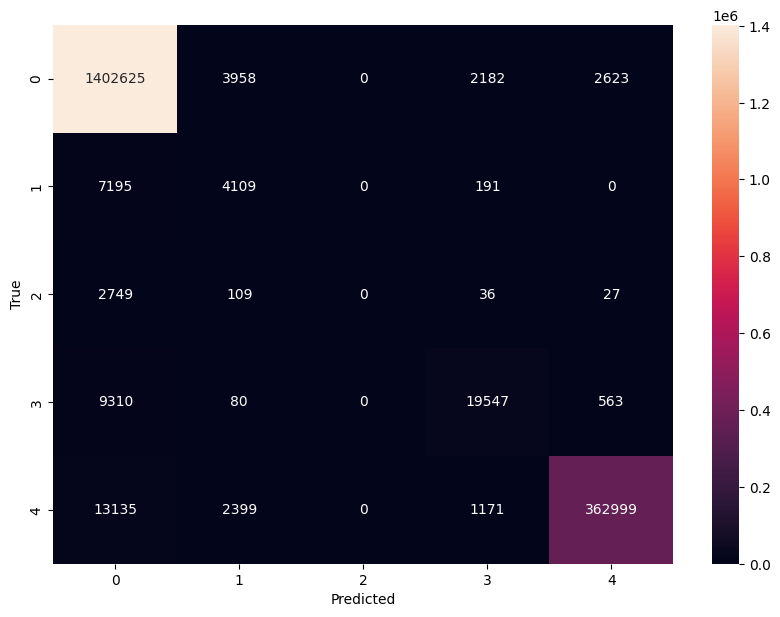

In [ ]:
cm = confusion_matrix(best_epoch_targets, best_epoch_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

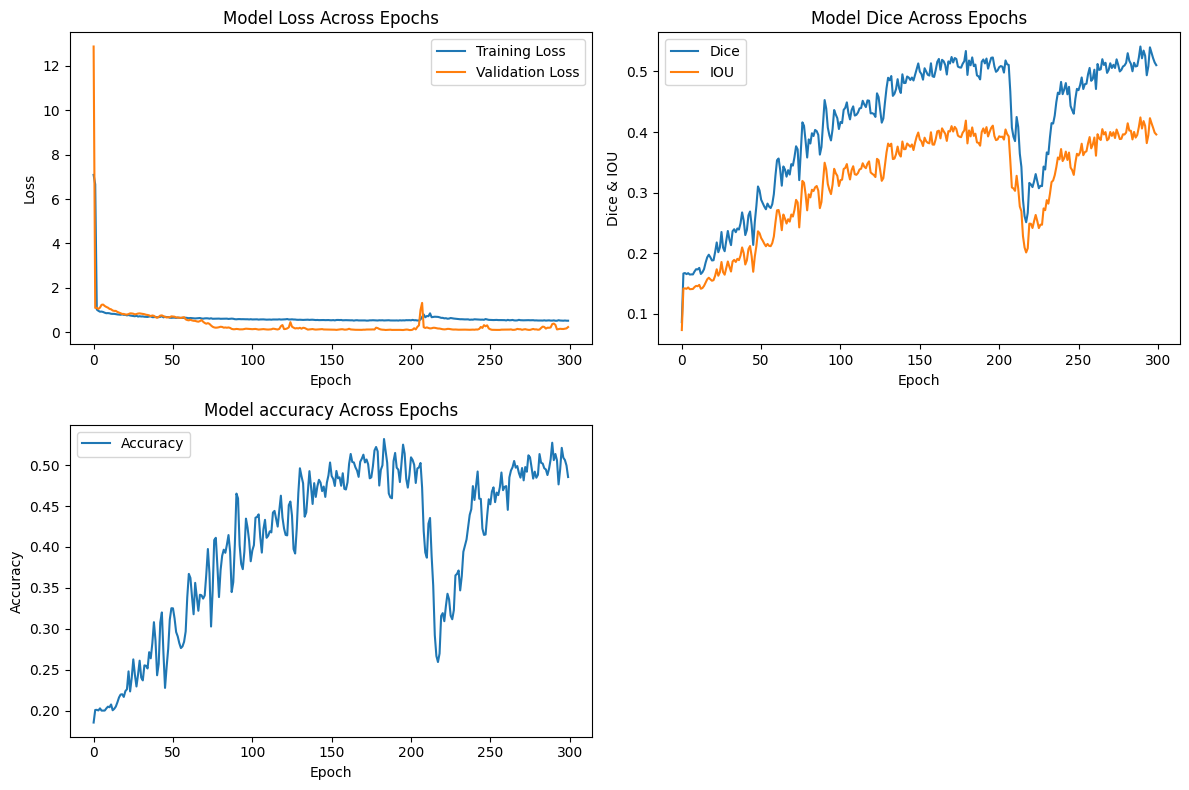

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting Dice
plt.subplot(2, 2, 2)
plt.plot(dices, label='Dice')
plt.plot(ious, label='IOU')
plt.title('Model Dice Across Epochs')
plt.ylabel('Dice & IOU')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(accs, label='Accuracy')
plt.title('Model accuracy Across Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.tight_layout()
plt.show()

# Test

Index: 0, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


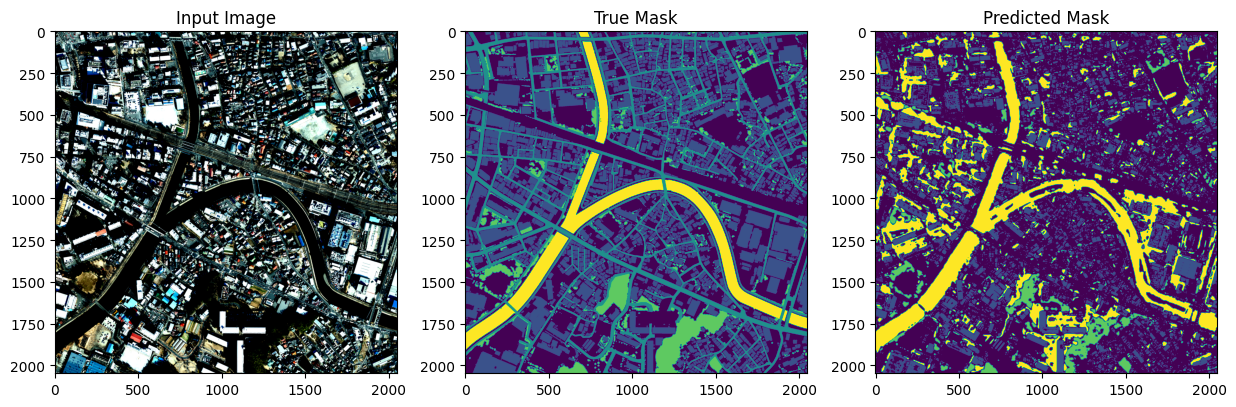

Index: 1, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


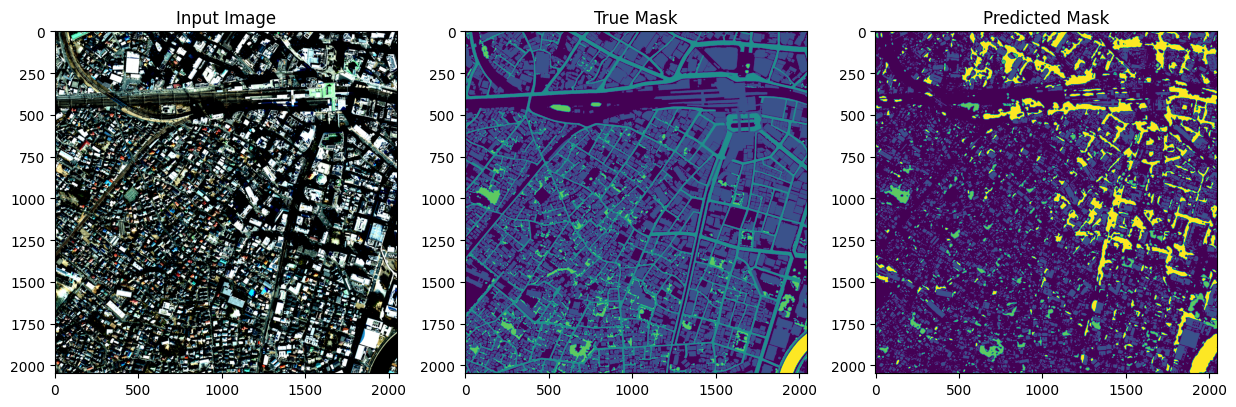

Index: 2, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


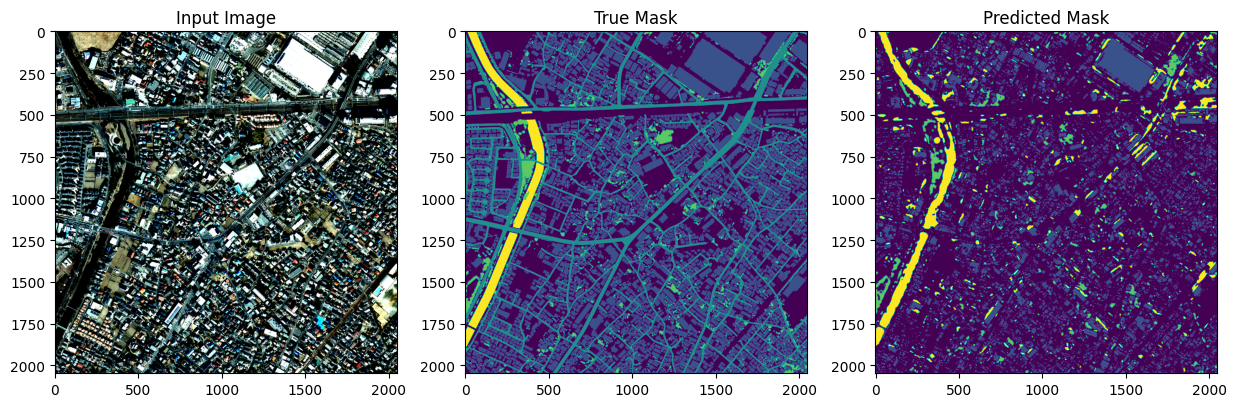

Index: 3, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


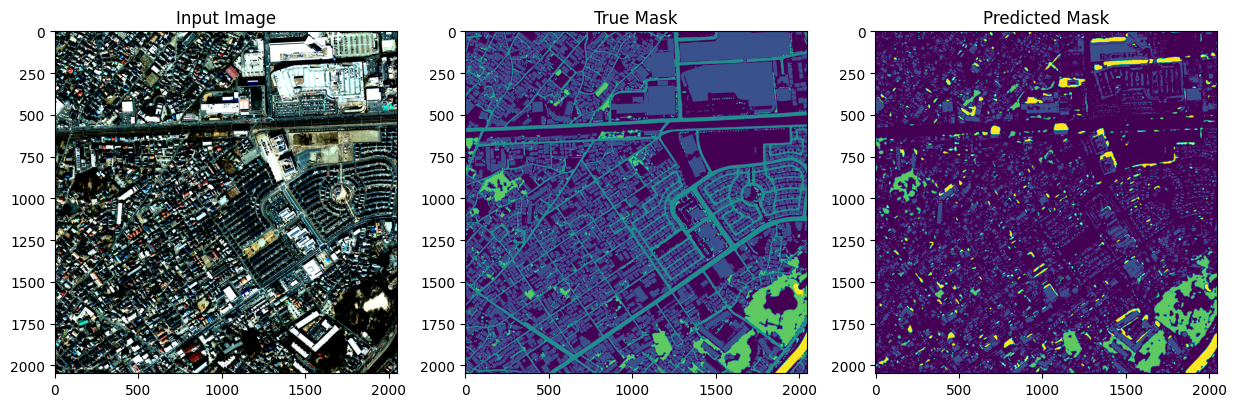

Index: 4, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3]


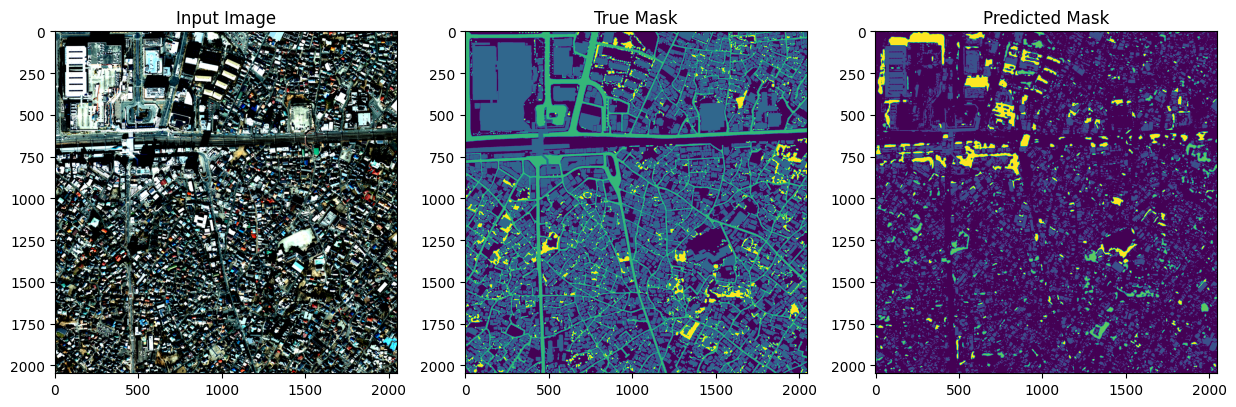

Index: 5, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3]


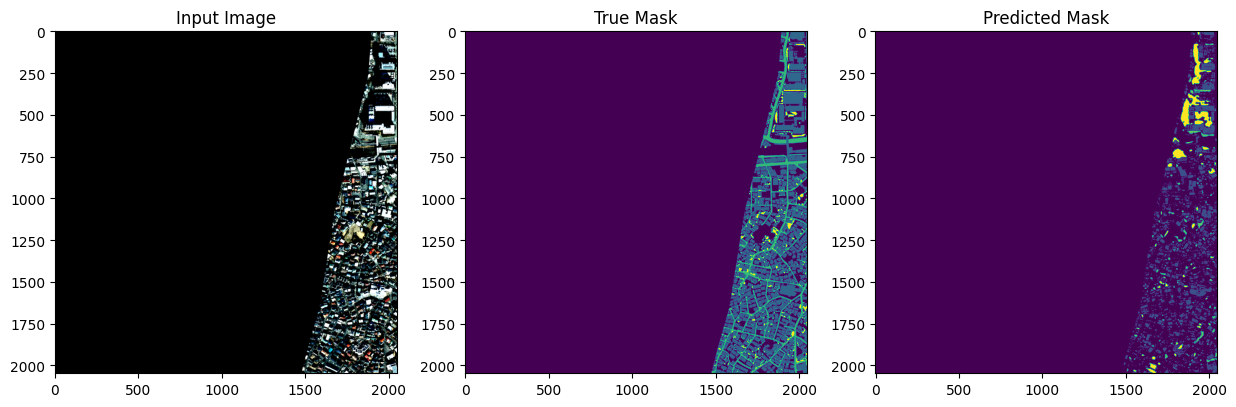

Index: 6, Unique Predicted Labels: [0], Unique True Labels: [0]


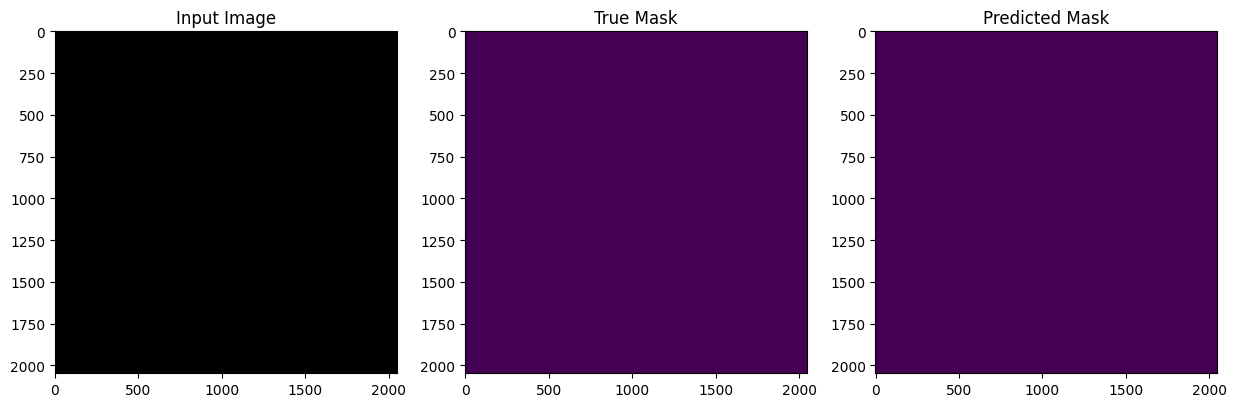

Index: 7, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 3]


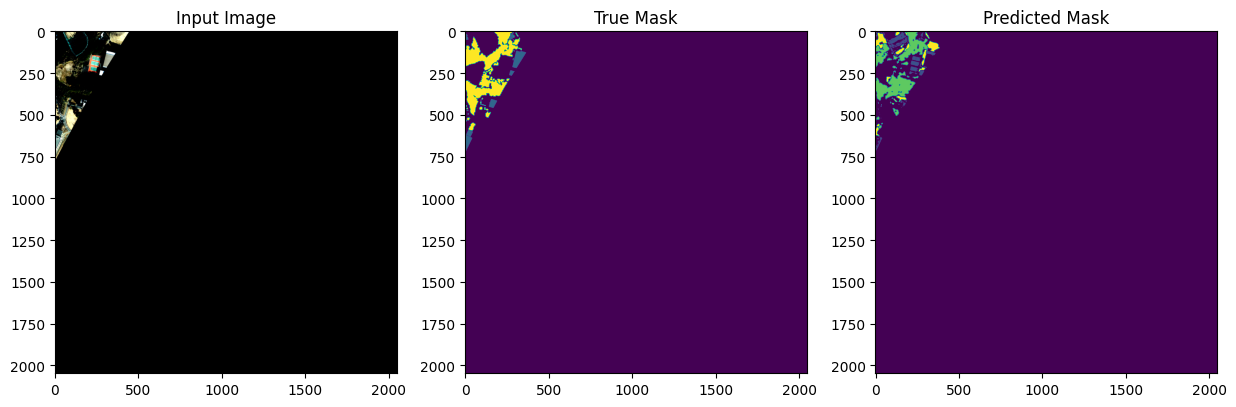

Index: 8, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


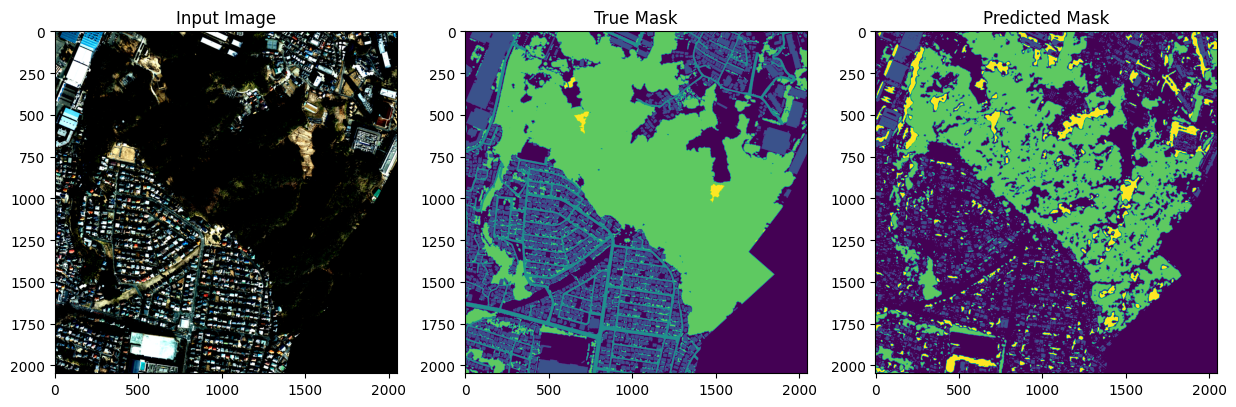

Index: 9, Unique Predicted Labels: [0 1 2 3 4], Unique True Labels: [0 1 2 3 4]


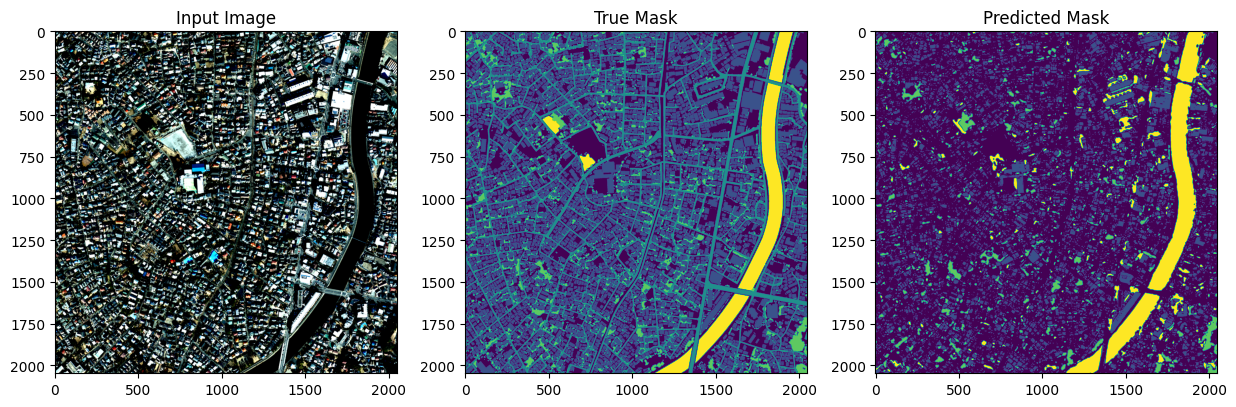

In [ ]:
import matplotlib.pyplot as plt

model.eval()
for idx in range(len(test_dataset)):
    with torch.no_grad():
        x, y = test_dataset[idx]
        x = x.unsqueeze(0).to(device)  # Add batch dimension and move to device
        y_hat = model(x)  # Shape: (batch_size, num_classes, H, W)
        y_hat_mask = y_hat.argmax(dim=1).squeeze().cpu()  # Get the predicted class labels

    print(f"Index: {idx}, Unique Predicted Labels: {np.unique(y_hat_mask)}, Unique True Labels: {np.unique(y)}")
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots
    axs[0].imshow(x.squeeze().cpu().permute(1, 2, 0))  # Display the input image
    axs[0].set_title('Input Image')
    axs[1].imshow(y)  # Display the ground truth mask
    axs[1].set_title('True Mask')
    axs[2].imshow(y_hat_mask)  # Display the predicted mask
    axs[2].set_title('Predicted Mask')
    plt.show()
